<a href="https://colab.research.google.com/github/javidv02/Automatizacion-IA4LEGOS/blob/main/Proyecto_final_IA4LEGOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto final Automatización en python IA4LEGOS 2024**

## Introducción

Buenas, soy Javier Maciá, un alumno del grado en estadística empresarial de la universidad Miguel Hernández de Elche. Últimamente estoy interesado en el mundillo de la inteligencia artificial y automatización, sobretodo en los grandes modelos de lenguaje, los sistemas RAG, agentes, fine tunning, etc.

Por el momento estoy más centrado en los sistemas RAG dado que me resulta intrigante obtener información en un par de consultas con un ordenador, resulta de lo más curioso.

En este curso nos han dado cancha para hacer el proyecto de lo que queramos siempre y cuando se automatice algo con los recursos proporcionados en las sesiones.

Es por esto que he centrado la mira en la obtención de información mediante api y web-scraping, información con la que alimentar un sistema RAG.

Hoy en día existe una cantidad ingente de información y la obtención de la misma es cada vez algo más tedioso, ya sea por demasiada cantidad fuentes, veracidad, anuncios, paginas de pago, clickbait, etc. Asumir toda esa información conlleva un trabajo de investigación que con las herramientas de hoy en día se puede optimizar. En este proyecto se resolverá aparentemente este problema.


## Objetivo
El objetivo del proyecto es poder obtener información sobre cualquier tema de cualquier web en cuestión de segundos y poder consultar esa información mediante chat.

El proyecto se dividirá en tres partes:
1. Obtención de informació mediante web scraping.
2. Obtención de información mediante api
3. Creación de un sistema RAG.

El resultado final será la unión de los métodos de obtención de información, priorizando la api. Con esto se creará un asistente al que se le proporcionará una consulta de tipo string y devolverá dos documentos, un archivo docx estilizado y un pdf en el directorio especificado de drive. El archivo docx es por si el usuario quiere leer el documento y el pdf se utiliza para la posterior consulta en el sistema RAG.

Una vez introducido el proyecto, nos ponemos manos a la obra.

# 1. Instalación y carga de librerías

Lo primero es empezar por los cimientos.

## Módulos empleados para la obtención de información:

1. **requests**  
   Este módulo se utiliza para hacer solicitudes HTTP en Python. Es útil para interactuar con APIs y descargar contenido de la web.

2. **bs4**  
   Beautiful Soup (bs4) es una biblioteca para extraer datos de archivos HTML y XML. Es comúnmente usada para web scraping.

3. **datetime**  
   Proporciona clases para manipular fechas y horas. Es útil para realizar operaciones con tiempos y fechas en Python.

4. **PyPDF2**  
   Una biblioteca para manipular archivos PDF. Permite leer, modificar y escribir documentos PDF.

5. **python-docx**  
   Se utiliza para crear, modificar y extraer información de archivos de Microsoft Word (.docx).

6. **selenium**  
   Selenium es una herramienta para la automatización de navegadores web. Es utilizada para pruebas automáticas de aplicaciones web y web scraping.

7. **groq**  
   Groq es una herramienta para escribir y ejecutar consultas en bases de datos Groq. (Nota: Verificar la documentación específica para más detalles, ya que puede no ser un módulo comúnmente conocido).

8. **eventregistry**  
   Event Registry es una API para obtener noticias y eventos de todo el mundo. El módulo `eventregistry` permite interactuar con esta API.

9. **reportlab**  
El módulo/librería ReportLab es una poderosa herramienta de generación de documentos PDF.


In [ ]:
!pip install requests bs4 datetime PyPDF2 python-docx selenium groq eventregistry reportlab

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import datetime
import time
import os
import requests
import docx
from docx import Document
from groq import Groq
from eventregistry import *
from google.colab import userdata
import subprocess

from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph
from reportlab.lib.styles import getSampleStyleSheet
from PyPDF2 import PdfReader, PdfWriter
import io

## Módulos empleados para el sistema RAG

1. **langchain**  
   Facilita la creación de aplicaciones que integran modelos de lenguaje con diferentes fuentes de datos.

2. **chromadb**  
   Base de datos optimizada para el almacenamiento y recuperación de grandes cantidades de datos.

3. **transformers**  
   Proporciona acceso a modelos de transformación (BERT, GPT, etc.) para tareas de PLN.

4. **langchain-community**  
   Extensión de `langchain` con integraciones y mejoras desarrolladas por la comunidad.

5. **pypdf**  
   Permite manipular y extraer texto de documentos PDF.

6. **sentence-transformers**  
   Facilita la creación de modelos de transformación de oraciones para comparación semántica.

In [ ]:
!pip install langchain==0.0.324 chromadb==0.4.15 transformers langchain-community pypdf==3.16.4 sentence-transformers==2.2.2

In [ ]:
import tempfile
import chromadb
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoModel
from chromadb.utils import embedding_functions


## Configuración del navegador

El siguiente código está escrito en un bloque de shell y se utiliza para configurar un sistema Debian para instalar `chromium` y `chromium-driver` desde los repositorios de Debian. Es el mismo código empleado en las sesiones del curso.



In [ ]:
%%shell
# Añadimos el buscador Debian
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Añadimos y almacenamos las claves necesarias
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Fijamos la APT para conseguir el paquete chromium
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Instalamos chromium y chromium-driver
apt-get update
apt-get install chromium chromium-driver

## Personalización del navegador

Los argumentos de la configuración son:


*   `--headless`: Este argumento permite ejecutar Chrome en modo "headless", lo que significa que el navegador se ejecutará sin una interfaz gráfica. Es útil para entornos de servidor donde no se requiere una interfaz de usuario.

*   `--no-sandbox`: Desactiva el modo sandbox de Chrome. Esta opción es necesaria en algunos entornos de contenedores y virtualización donde el sandboxing puede causar problemas.


*   `--disable-dev-shm-usage`: Este argumento deshabilita el uso compartido de memoria /dev/shm, lo que puede ser necesario en sistemas con poca memoria compartida disponible.









In [ ]:
# Importamos el módulo webdriver
from selenium import webdriver
# Importamos la función Service
from selenium.webdriver.chrome.service import Service

# Indicamos el servicio (navegador) que vamos a utilizar
servicio = Service(executable_path=r'/usr/bin/chromedriver')

# Variable que almacena la configuración de nuestro navegador
opciones = webdriver.ChromeOptions()
# Añadimos argumentos para modificar nuestro navegador
opciones.add_argument("--headless")
opciones.add_argument("--no-sandbox")
opciones.add_argument('--disable-dev-shm-usage')

# Variable que nos servirá para navegar por Google Chrome
navegador = webdriver.Chrome(service=servicio, options=opciones)

## Groq

Groq es la empresa de infraestructura de IA que construye la tecnología de inferencia de IA más rápida del mundo.

En la misma página se encuentra toda la documentación de la api y su implementación en python.

Permite utilizar los mejores modelos open source hasta la fecha: Llama 70b y Mixtral 8x7b, o algunos más normales como Llama 8b o gemma 7b de forma totalmente gratuita.

Para cada modelo existen unos límites, los cuales son bastantes generosos:

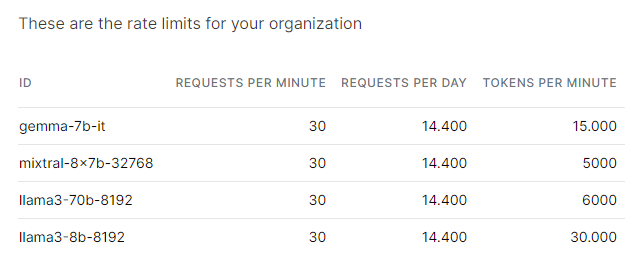



 Además la velocidad de escritura es vertiginosa con velocidades de hasta 250 tokens por segundo.

Una vez introducido qué es Groq, procedemos a definir unos 'asistentes', modelos que facilitarán la creación del codigo.

En este caso se ha definido un generador de resumenes, un clasificador y un corrector, que servirán para adaptar la información de entrada y de salida.

In [ ]:
os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

assert os.environ.get('GROQ_API_KEY') is not None, "La variable de entorno GROQ_API_KEY no está establecida"

#### GENERADOR DE RESUMENES

def obtener_resumen(client, json):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
                Asistente de Resumen de Noticias

Este asistente está diseñado para proporcionarte un resumen conciso de las noticias más relevantes del momento. Analizará las noticias disponibles y seleccionará las más destacadas para ti.

Instrucciones para el Asistente:

Analiza las noticias disponibles.
Selecciona las noticias más relevantes.
Transforma la informacion proporcionada en un resumen en castellano redactado de la información introducida, puedes añadir listas y apartados. Deberás indicar para cada noticia la fecha de publicación y el autor.
Unifica la redacción de las noticias, la redacción deberá contener las noticias más relevantes al principio. Proporciona el texto en formato rmarkdown, estilizando los encabezados y las listas.
Debes proporcionar un resumen de la información proporcionada en el json.

Estructura del JSON:

[
  {
    "title": "Título de la Noticia",
    "url": "URL de la Noticia",
    "time_published": "Fecha y Hora de Publicación",
    "authors": ["Autor(es)"],
    "summary": "Resumen de la Noticia"
  },
  ...
]
Ejemplo:


[
  {
    "title": "What Percentage Of Stock Trades Are Made By Bots And Algorithms?",
    "url": "https://www.benzinga.com/general/topics/23/06/32861724/what-percentage-of-stock-trades-are-made-by-bots-and-algorithms",
    "time_published": "14/06/2023 18:19:28",
    "authors": ["AJ Fabino"],
    "summary": "This year's market story has been artificial intelligence, illustrated by the recent rush into tech stocks and investor interest in any company working on, or with AI and generative AI."
  },
  ...
]
                """
            },
            {
                "role": "user",
                "content": f"{json}"
            }
        ],
        model="llama3-70b-8192",
    )

    return chat_completion.choices[0].message.content

#### CLASIFICADOR DE PETICIONES

def clasificador(client,peticion):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
                Eres un robot que clasifica peticiones. Deberás extraer las palabras clave de la petición y devolver una lista con las palabras clave que hayas obtenido.
                Tan solo deberás devolver la lista. Como un robot, no digas nada más.
                Instrucciones:
                - La lista NO lleva ni corchetes ni paréntesis al principio ni al final. Serán palabras separadas por comas.
                - Las palabras de la lista tienen que estar directamente relacionadas con lo que se pide en la petición.
                - En ningún caso proporcionarás frases, ni palabras que estén fuera de contexto.
                - Las respuestas deben ser ultra precisas.
                """
            },
            {
                "role": "user",
                "content": f"{peticion}"
            }
        ],
        model="llama3-70b-8192",
        temperature = 1,
    )

    return chat_completion.choices[0].message.content

#### CORRECTOR DE TEXTOS:

def corrector(client,peticion):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": """
                Eres un corrector experto en todos los idiomas. Tu tarea consiste en corregir y mejorar la redacción de cualquier texto que se te proporcione. Además deberás traducir todos los textos que se te proporcionen, al español.
                Debes proporcionar correcciones de la más alta fiabilidad y calidad.
                SOLO PROPORCIONA LA CORRECCIÓN. NO INCLUYAS NINGUNA INFORMACIÓN ADICIONAL O COMENTARIOS. RESPONDE ÚNICAMENTE CON EL TEXTO CORREGIDO EN ESPAÑOL.
                """
            },
            {
                "role": "user",
                "content": f"{peticion}"
            }
        ],
        model="llama3-8b-8192", # como deberá corregir bastante texto, se utiliza el modelo que más tokens por minuto tiene.
        temperature = 1,
    )
    return chat_completion.choices[0].message.content





# Obtención de información mediante web scraping.

La parte de obtención de información comienza aquí. Estas son las primeras funciones que nos servirán para extraer el contenido de las páginas.

Se han creado dos funciones: obtener_pdf() y obtener_contenido_docx(). Que como indican sus nombres son funciones para obtener pdf y obtener el contenido de la página en un documento docx.

Hay mejores formas de obtener información que con el web scraping, como es la uso de apis. En este caso la obtención mediante api se definirá más adelante. De todas formas hay que leerse bien los términos de política y privacidad de la web que se está scrapeando para no cometer ninguna infracción legal.

En este caso, el reto del proyecto es obtener información de cualquier sitio web y como es de esperar no podré leerme todos los términos de política y privacidad, así que he optado por utilizar el código solo para este proyecto, sin publicar nada ni beneficiarme de terceros. Para minimizar riesgos más que nada.

## Explicación de la función `obtener_pdf`

La función `obtener_pdf` busca y descarga archivos PDF desde una página web. A continuación se explica su funcionamiento:

### Parámetros

- **soup**: Es un objeto de BeautifulSoup que contiene el contenido HTML de una página web. Se utiliza para buscar elementos dentro de la página.
- **i**: Un índice que se utiliza para numerar los archivos PDF descargados, ayudando a evitar nombres de archivo duplicados.
- **lista_pdf**: Una lista de palabras clave. La función verifica que al menos una de estas palabras esté presente en los enlaces antes de descargar el archivo PDF.

### Funcionamiento

1. **Buscar enlaces PDF**: La función utiliza `soup` para encontrar todos los elementos `<a>` con el atributo `href`.

2. **Verificar enlaces**: Para cada enlace encontrado, se obtiene el valor del atributo `href` y se comprueba si contiene alguna de las palabras clave de `lista_pdf` y si el enlace termina con `.pdf`.

3. **Descargar el PDF**: Si un enlace cumple con los criterios, se realiza una solicitud HTTP para descargar el archivo PDF. Luego, el archivo se guarda en una ubicación específica definiendo el nombre como la búsqueda que se ha realizado y el índice `i`.

4. **Guardar el archivo**: El archivo PDF se guarda en la ruta especificada con un nombre único para evitar conflictos.

5. **Mensaje de confirmación**: Si se descarga un PDF, se imprime un mensaje confirmando la descarga y la ubicación del archivo. Si no se encuentran enlaces PDF, se imprime un mensaje indicando que no se encontraron archivos PDF para descargar.

## Explicación de la función `obtener_contenido_docx`

La función `obtener_contenido_docx` extrae y guarda contenido de una página web en un documento DOCX. A continuación, se detalla su funcionamiento:

### Parámetros

- **soup**: Objeto de BeautifulSoup que contiene el contenido HTML de una página web.
- **i**: Índice utilizado para numerar las búsquedas y organizar el contenido.
- **enlace**: URL de la página web de donde se extrae el contenido.
- **archivo_docx**: Ruta del archivo DOCX donde se guardará el contenido extraído.

### Funcionamiento

1. **Crear/abrir el documento DOCX**: Se abre el archivo DOCX especificado o se crea uno nuevo si no existe.

2. **Agregar encabezado inicial**: Se añade un encabezado con el número de búsqueda y la URL de la página web.

3. **Buscar encabezados HTML**: La función busca todos los encabezados (`h1` a `h6`) en el contenido HTML.

4. **Obtener y procesar elementos**: Para cada encabezado encontrado, se obtienen todos los elementos siguientes (párrafos y listas) hasta el próximo encabezado de nivel igual o superior:
   - **Párrafos**: Si el párrafo tiene más de 100 caracteres, se agrega al documento bajo el encabezado correspondiente.
   - **Listas**: Si al menos un elemento de la lista tiene más de 100 caracteres, se agrega al documento bajo el encabezado correspondiente. Las listas se formatean como viñetas o listas numeradas según corresponda.

5. **Agregar separador**: Se añade una línea de separación (`---`) para delimitar el contenido de diferentes búsquedas.

6. **Guardar el documento**: El archivo DOCX se guarda con el contenido extraído.

7. **Mensaje de confirmación**: Se imprime un mensaje indicando que el contenido ha sido añadido al archivo DOCX.


In [ ]:
def obtener_pdf(soup, i, lista_pdf):
   enlaces_pdf = soup.find_all("a", href=True)
   pdf_encontrado = False
   for enlace_pdf in enlaces_pdf:
       href = enlace_pdf.get("href")
       if any(palabra in href.lower() for palabra in lista_pdf) and href.endswith('.pdf'):
           response = requests.get(href)
           nombre_archivo = os.path.join(ruta_de_guardado, f"{busqueda.replace(' ', '_')}_{i+1}.pdf")
           with open(nombre_archivo, 'wb') as pdf_file:
               pdf_file.write(response.content)
           print(f"PDF de la web '{navegador}' descargado en:", nombre_archivo)
           pdf_encontrado = True
   if not pdf_encontrado:
       print("\n\t\t>> No se encontraron enlaces PDF para descargar.")


def obtener_contenido_docx(soup, i, enlace, archivo_docx):
    document = Document(archivo_docx)
    document.add_heading(f"Contenido de la búsqueda {i+1}\nFuente: {enlace}\n", level=1)

    for encabezado in soup.find_all(["h1", "h2", "h3", "h4", "h5", "h6"]):
        encabezado_texto = encabezado.get_text()
        encabezado_agregado = False

        # Obtener todos los elementos (párrafos, listas) dentro del encabezado
        elementos = encabezado.find_all_next(["p", "ul", "ol"])

        for elem in elementos:
            if elem.name == "p" and len(elem.get_text(strip=True)) > 100:
                if not encabezado_agregado:
                    document.add_heading(encabezado_texto, level=int(encabezado.name[1])-1)
                    encabezado_agregado = True
                document.add_paragraph(elem.get_text())
            elif elem.name in ["ul", "ol"]:
                lista_texto = " ".join([li.get_text() for li in elem.find_all("li")])
                if any(len(li.get_text(strip=True)) > 100 for li in elem.find_all("li")):
                    if not encabezado_agregado:
                        document.add_heading(encabezado_texto, level=int(encabezado.name[1])-1)
                        encabezado_agregado = True
                    for li in elem.find_all("li"):
                        if len(li.get_text(strip=True)) > 100:
                            document.add_paragraph(li.get_text(), style='ListBullet' if elem.name == "ul" else 'ListNumber')

    document.add_paragraph("---")  # Separador entre contenidos
    document.save(archivo_docx)
    print("\n\t>> Contenido añadido en:", archivo_docx)





## Drive
Ahora definimos el directorio de drive. Este directorio será diferente para cada uno, por lo que es imprescindible que se especifique.

In [ ]:
# primero introducimos una ruta de guardado
from google.colab import drive
drive.mount('/content/drive')

# cambiar en función de cada uno
ruta_de_guardado = "/content/drive/MyDrive/"

## Convertir_docx_a_pdf:

Antes de explicar el codigo principal, lo que se hace es crear una función que permita guardar el archivo docx como pdf. Dado que el RAG está configurado para que solo funcione con pdf. La función coge los párrafos del archivo docx y los almacena en un archivo pdf.

In [ ]:
def convertir_docx_a_pdf(archivo_docx):
    # Obtener el nombre del archivo sin la extensión
    nombre_archivo, _ = os.path.splitext(archivo_docx)
    archivo_pdf = nombre_archivo + ".pdf"

    # Leer el contenido del archivo DOCX
    doc = Document(archivo_docx)
    content = []
    for paragraph in doc.paragraphs:
        content.append(paragraph.text)

    # Crear un nuevo documento PDF
    pdf_document = SimpleDocTemplate(archivo_pdf, pagesize=letter)
    styles = getSampleStyleSheet()

    # Agregar el contenido del archivo DOCX al PDF
    paragraphs = [Paragraph(text, styles["Normal"]) for text in content]
    pdf_document.build(paragraphs)

    print("Archivo PDF creado:", archivo_pdf)

## Codigo principal obtención de información mediante web scraping



### Explicación `Buscador(peticion, ruta, num_enlaces)`
La función `buscador` está diseñada para realizar búsquedas en línea, recopilar información relevante de los enlaces encontrados y organizarla en documentos y archivos PDF.

La función `buscador` acepta los siguientes parámetros:

- `peticion`: Es la palabra clave de búsqueda o el conjunto de palabras clave que se utilizarán para buscar información en línea.
- `ruta_de_guardado`: Es la ruta donde se guardarán los documentos generados (archivos DOCX y PDF).
- `num_enlaces`: Especifica el número máximo de enlaces relevantes que se recopilarán y procesarán por cada búsqueda.

A continuación se explica su funcionamiento paso a paso:

1. **Inicialización de Variables:**
   - `buscar`: Una lista que contiene la palabra clave de búsqueda proporcionada en `peticion`. Permite buscar múltiples palabras clave si se modifica el código.
   - `nombres_archivo`: Una lista que nombra los archivos de salida basados en la palabra clave de búsqueda.
   - `lista_buscar`: Lista que encapsula todas las búsquedas a realizar.
   - `lista_pdf`: Lista que inicialmente contiene el resultado de la función `clasificador`, que puede identificar patrones en los títulos de los archivos PDF.

2. **Iteración a través de las Búsquedas:**
   - Para cada término de búsqueda en `lista_buscar`:
     - Se obtiene el año actual para incluirlo en la búsqueda y asegurar que los resultados sean recientes.
     - Se define el nombre y la ubicación del archivo de documento Word (`archivo_docx`) donde se almacenará la información recopilada.

3. **Creación del Archivo Docx:**
   - Si el archivo `archivo_docx` no existe, se crea un nuevo documento vacío utilizando la biblioteca `python-docx`.

4. **Inicialización del Navegador Web:**
   - Se inicia un navegador Chrome mediante WebDriver, configurado con opciones específicas (`servicio` y `opciones`).

5. **Búsqueda en Google:**
   - Para cada término de búsqueda (`busqueda`):
     - El navegador accede al sitio web de Google.
     - Encuentra y borra cualquier contenido previo en la barra de búsqueda.
     - Ingresa la palabra clave de búsqueda junto con el año y "en español" para obtener resultados actualizados y en español.
     - Realiza la búsqueda y espera brevemente para que los resultados se carguen.

6. **Obtención de Enlaces Relevantes:**
   - Se obtienen los enlaces de las páginas web que aparecen en los resultados de búsqueda, filtrando aquellos que comienzan con "https://" y excluyendo los enlaces de YouTube.

7. **Recopilación de Información:**
   - Para cada enlace filtrado:
     - Se intenta acceder al enlace y obtener el contenido HTML.
     - Si se logra acceder (status code 200), se utiliza BeautifulSoup para analizar el contenido y encontrar el cuerpo (`<body>`) de la página.
     - Se llama a las funciones `obtener_contenido_docx` y `obtener_pdf` para procesar y guardar la información relevante en el documento Word y en la lista de archivos PDF respectivamente.

8. **Generación de Archivos PDF:**
   - Después de recopilar la información de todos los enlaces relevantes para una búsqueda específica, se convierte el documento Word (`archivo_docx`) en un archivo PDF usando `convertir_docx_a_pdf`.

9. **Cierre del Navegador:**
   - Finalmente, se cierra el navegador Chrome.

Este proceso se repite para cada término de búsqueda en `lista_buscar`, lo que permite recopilar información estructurada y organizada en documentos y archivos PDF para cada búsqueda realizada.


In [ ]:
def buscador(peticion, ruta_de_guardado, num_enlaces):

  # se utilizan listas por si se quiere modificar el codigo y buscar varias cosas al mismo tiempo. El codigo itera la lista de busqueda y crea archivos para cada una.
  buscar = [f"{peticion}"]
  nombres_archivo=[f"{peticion}"]
  lista_buscar=[buscar]
  lista_pdf=[clasificador(client,peticion)] # en caso de conocer el patrón de los títulos de los pdf, se puede introducir manualmente.


  for j,buscar in enumerate(lista_buscar):
    fecha_actual = datetime.datetime.now()
    año = fecha_actual.year

    archivo_docx = os.path.join(ruta_de_guardado, buscar[j] + ".docx") # el archivo se nombrará por la búsqueda. En caso de que ya exista, se añadirá el contenido de la nueva busqueda al documento.

    if not os.path.exists(archivo_docx):
        document = Document()
        document.save(archivo_docx)

    navegador = webdriver.Chrome(service=servicio, options=opciones)

    for busqueda in buscar:

      print("\n-> Buscando:",busqueda,"...")
      navegador.get("http://www.google.com") # nos situamos en el buscador de google
      buscador = navegador.find_element(By.NAME, "q") # encontramos la barra de navegación
      buscador.clear() # borramos lo que esté escrito de antes

      buscador.send_keys(busqueda + f" {año} en español") # se añade el año y 'en español' para que los resultados sean actualizados y en español para facilitar la tarea al corrector. Aunque no siempre funciona.
      buscador.send_keys(Keys.ENTER) # buscamos

      time.sleep(2)

      enlaces = navegador.find_elements(By.XPATH, value="//a[@jsname='UWckNb']") # encontramos todos los enlaces de las páginas
      enlaces = [enlace.get_attribute("href") for enlace in enlaces if enlace.get_attribute("href") and enlace.get_attribute("href").startswith("https://") and 'youtube' not in enlace.get_attribute("href")] # filtramos los enlaces que nos interesan
      enlaces_filtrados = enlaces[:num_enlaces] # buscamos en los n primeros enlaces, modificar a las necesidades de cada uno

      # se iteran las paginas recopilando la información
      for i, enlace in enumerate(enlaces_filtrados):
        try:
          response = requests.get(enlace)

          if response.status_code != 200:
            print(f"\n\t>> Error al acceder al enlace: {enlace} - Status code: {response.status_code}")
            continue

          html = response.content
          soup = BeautifulSoup(html, 'html.parser').find('body')
          obtener_contenido_docx(soup,i,enlace,archivo_docx)
          obtener_pdf(soup,i,lista_pdf)
        except Exception as e:
          print(f"\n\t>> No se pudo procesar el enlace: {e}")
      convertir_docx_a_pdf(archivo_docx) # finalmente se genera un pdf a partir del documento word.
    navegador.quit()


Ejemplo de uso:

NOTA: El tiempo de ejecución depende de la hora y la saturación de la web que se está scrapeando.

In [ ]:
buscador("Qué son los odds ratios?", ruta_de_guardado, num_enlaces = 3)

## Obtención de información mediante API.

Como se ha comentado anteriormente, aquí se definirá la obtención mediante api, método que se priorizará a la hora de la obtención de información.

Lo primero que se hará será definir una función que permita crear un documento ".docx" a partir del json de la api.

En segundo lugar se genará un resumen en formato docx con la información. Información que se obtiene a partir del asistente de resúmenes.

Al asistente que genera los resumenes se le ha instruído para que proporcione los resumenes en formato rmd para que después sea más fácil filtrar las listas y los encabezados a la hora de estilizarlos.

In [ ]:
def crear_documento_pdf(texto_rmd, nombre_archivo):
    # Inicializar el documento PDF
    pdf_document = SimpleDocTemplate(nombre_archivo, pagesize=letter)
    styles = getSampleStyleSheet()

    # Dividir el texto en líneas
    lineas = texto_rmd.split('\n')

    # Lista para almacenar todos los elementos del documento
    content = []

    for linea in lineas:
        # Si la línea comienza con '#', se trata de un encabezado
        if linea.startswith('#'):
            nivel_encabezado = linea.count('#')
            texto_encabezado = linea.strip('#').strip()
            content.append(Paragraph(texto_encabezado, styles['Heading%d' % nivel_encabezado]))

        # Si la línea comienza con '-' o '*', se trata de un elemento de lista
        elif linea.startswith('-') or linea.startswith('*'):
            content.append(Paragraph(linea.strip('-*').strip(), styles['Bullet']))

        # Si la línea no comienza con '#', '-' ni '*', se trata de texto normal
        else:
            content.append(Paragraph(linea, styles['Normal']))

    # Construir el documento PDF
    pdf_document.build(content)

    print("\n\t>> Archivo PDF creado:", nombre_archivo)


#### API
Se ha decidido utilizar una api de noticias para el proyecto. Esta api proporciona una lista de json donde las claves son los elementos de los artículos.

Además, para esta función hay que introducir una peticion y automáticamente se genera el resultado en función de lo deseado. Se obtendrá el título, la url, la fecha de publicación, los autores, un resumen y la relevancia, para los 5 primeros artículos.

In [ ]:
# Inicializar el objeto EventRegistry con la clave API
er = EventRegistry(apiKey=userdata.get('NEWSAI_API'), allowUseOfArchive=False)

def noticias(peticion):
  palabras_clave = clasificador(client, peticion) # se clasifica la petición por palabras clave para la consulta a la api. No admite consultas solo palabras.
      # Crear la consulta con los parámetros deseados
  q = QueryArticlesIter(
      keywords=[palabras_clave],  # Palabras clave para la búsqueda
      dataType=["news"],
      lang=["spa"],
      startSourceRankPercentile=70

  )

  # Lista para almacenar la información extraída de cada artículo
  extracted_info_noticias = []
  maxItems=10 # número máximo de artículos
  for article in q.execQuery(er, sortBy="date", maxItems=maxItems, startSourceRankPercentile=70):
      for i in range(maxItems):
        info = {
            'title': article.get('title'),
            'url': article.get('url'),
            'time_published': article.get('date'),
            'authors': article.get('author', {}).get('name', 'Unknown'),  # Obtener el nombre del autor, si está disponible
            'summary': article.get('body', '')[:150],  # Muestra solo los primeros 150 caracteres del cuerpo. El asistente deberá resumir todo el texto por lo que cuanto menos artículos más texto podremos obtener.
            'relevancia': article.get('relevance', 'Unknown')  # Obtener la relevancia, si está disponible
        }
        extracted_info_noticias.append(info)

  return extracted_info_noticias



Ejemplo de uso:

(A veces se atasca, tener paciencia y volver a ejecutar)

In [ ]:
obtener_resumen(client,noticias("Noticias España"))

Finalmente se unen los dos métodos de extracción, priorizando la api. En caso de que no se halle información relevante en la api, el usuario deberá decidir si obtener la información mediante web scraping.

Aviso: los resultados variarán en función de la página en la que se esté buscando.

In [ ]:
def asistente(peticion, ruta_de_guardado):
    print('-> Procesando peticion...')

    print('\n-> Buscando en api...')
    if not os.path.exists(ruta_de_guardado):
        os.makedirs(ruta_de_guardado)
        print(f"Ruta de guardado creada: {ruta_de_guardado}")

    contenido_api=noticias(peticion)
    if contenido_api:
      print('\n\t>> Obteniendo información...')
      archivo_pdf=None
      archivo_pdf = os.path.join(ruta_de_guardado, f"{peticion}" + ".pdf")
      contenido = obtener_resumen(client, contenido_api)
      print('\n\t>> Creando archivo...')
      crear_documento_pdf(contenido, archivo_pdf)
    else:
      archivo_docx=None
      respuesta = int(input("\nAviso: No se ha encontrado nada vía api.¿Desea continuar la búsqueda mediante web-scraping? (1:Sí o 2:No): "))
      if respuesta==1:
        print(f"\nSe procede a buscar mediante web-scraping.")
        buscador(peticion, ruta_de_guardado,3)

    return print("\nProceso completado")


## Resultado del asistente

El tiempo de espera puede variar en función de la cantidad de texto y de la hora.

Como es de esperar, la api proporcionará resultados cuando la consulta esté relacionada con las noticias.

In [ ]:
asistente("fichaje Mbappé",ruta_de_guardado)

Y mediante api se obtiene:

In [ ]:
asistente("Novedades modelos llm open source", ruta_de_guardado)

# Sistema RAG

Finalmente aquí está la creación del RAG. No es ultra preciso pero si que sirve para muchos casos, además es bastante rápido haciendo los embeddings.

### Descripción de Funciones

Este código ha sido adaptado de un código que he encontrado en github.

La fuente es la siguiente: https://github.com/NechuBM/ChatChromaDB/blob/main/ChromaDB.ipynb

#### `setup_chroma_client`
Configura el cliente de ChromaDB para su uso en el sistema.

#### `save_name_files`
Guarda los nombres de nuevos archivos PDF en una lista, asegurándose de no duplicar entradas.

#### `load_name_files`
Carga la lista de nombres de archivos PDF previamente guardados.

#### `clean_files`
Limpia la lista de nombres de archivos y reinicia la colección en ChromaDB, eliminando cualquier dato anterior.

#### `text_to_chromadb`
Convierte el contenido de un archivo PDF en texto y lo guarda en ChromaDB como vectores para su posterior recuperación.

#### `create_embeddings`
Crea vectores de los fragmentos de texto extraídos de los PDFs, utilizando un modelo de embeddings. Estos vectores se almacenan en ChromaDB.

#### `ChatRag`
Interfaz principal del sistema. Permite a los usuarios realizar preguntas, buscar respuestas en los textos almacenados y limpiar el sistema cuando sea necesario.

#### `main`
Configura el sistema, muestra los archivos PDF disponibles, permite al usuario seleccionar un archivo y procesa el archivo seleccionado para su almacenamiento en ChromaDB.

### Flujo General

1. **Configuración Inicial**: El sistema se configura cambiando el directorio de trabajo y configurando ChromaDB.
2. **Carga de Archivos**: Se muestran los archivos PDF disponibles al usuario.
3. **Selección y Procesamiento**: El usuario selecciona un archivo, que se procesa y almacena en ChromaDB.
4. **Interacción con el Usuario**: Los usuarios pueden hacer preguntas y el sistema busca respuestas en los textos almacenados, devolviendo la información relevante.
5. **Mantenimiento**: Funciones para limpiar archivos y reiniciar la colección cuando sea necesario.

In [ ]:
os.chdir("/content/drive/MyDrive/")
FILE_LIST = "archivos.txt"
INDEX_NAME = 'Automatizacion_IA4LEGOS'
chroma_client = chromadb.Client()
collection = chroma_client.get_or_create_collection(name=INDEX_NAME)


def setup_chroma_client():
    global chroma_client
    chroma_client = chromadb.Client()

def save_name_files(path, new_files):
    old_files = load_name_files(path)
    with open(path, "a") as file:
        for item in new_files:
            if item not in old_files:
                file.write(item + "\n")
                old_files.append(item)
    return old_files

def load_name_files(path):
    archivos = []
    with open(path, "r") as file:
        for line in file:
            archivos.append(line.strip())
    return archivos

def clean_files(path):
    with open(path, "w") as file:
        pass
    chroma_client.delete_collection(name=INDEX_NAME)
    collection = chroma_client.create_collection(name=INDEX_NAME)
    return True

def text_to_chromadb(pdf, file_name):
    temp_dir = tempfile.TemporaryDirectory()
    temp_filepath = os.path.join(temp_dir.name, file_name)
    with open(temp_filepath, "wb") as f:
        f.write(pdf)
    loader = PyPDFLoader(temp_filepath)
    text = loader.load()
    create_embeddings(file_name, text)
    return True

def create_embeddings(file_name, text):
    print(f"Cargando archivo: {file_name}")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=700,
        chunk_overlap=70,
    )
    chunks = text_splitter.split_documents(text)
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
    )
    Chroma.from_documents(
        chunks,
        embeddings,
        client=chroma_client,
        collection_name=INDEX_NAME
    )
    return True


def ChatRag():
    FILE_LIST = "archivos.txt"
    INDEX_NAME = 'Automatizacion_IA4LEGOS'
    collection = chroma_client.get_or_create_collection(name=INDEX_NAME)
    client = Groq(
        api_key=userdata.get("GROQ_API_KEY"),
    )

    main()  # Verifica archivos al inicio

    while True:
        archivos = load_name_files(FILE_LIST)

        if archivos:
            user_question = str(input("Pregunta: "))
            if user_question == "reset":
              clean_files(FILE_LIST)
              chroma_client.delete_collection(INDEX_NAME)
              break
            elif user_question =="stop":
              break
            else:

              if user_question:
                  results = collection.query(
                      query_texts=user_question,  # Chroma will embed this for you
                      n_results=10  # how many results to return
                  )

                  contexto = results['documents']
                  fuentes = results['metadatas']
                  # Extracting file names from source paths
                  file_names = [os.path.basename(source[0]['source']) for source in fuentes]
                  contexto = f"Information: {contexto} and the sources: {file_names}"
                  sys_prompt = f"""
                  Instructions:
                  - El resultado debe ser eficiente, preciso y adaptado a la intención original del usuario. Evita la ambigüedad y la vaguedad.
                  - Eres un asistente experto en la síntesis de información. Deberás proporcionar respuestas en base al contexto proporcionado. ¡SI LA PREGUNTA DEL USUARIO NO SE PUEDE RESPONDER CON EL CONTENIDO DEL TEXTO, RESPONDE QUE NO LO SABES!
                  - RESPONDE BASÁNDOTE ÚNICAMENTE EN LA INFORMACIÓN PROPORCIONADA.
                  - No aportes ninguna información extra que no aparezca en el contexto proporcionado.
                  - Las respuestas deben ser argumentadas con el contexto, deben ser coherentes y deben ser de gran calidad. Además deberán ser respuestas estructuradas por parrafos y por puntos.
                  - Cita las fuentes
                  - RESPONDE PARA TODOS LOS CASOS ÚNICA Y EXCLUSIVAMENTE EN ESPAÑOL
                  Context: {contexto}
                  """
                  chat_completion = client.chat.completions.create(
                      messages=[
                          {
                              "role": "system",
                              "content": f"{sys_prompt}"
                          },
                          {
                              "role": "user",
                              "content": f"{user_question}",
                          }
                      ],
                      model="llama3-70b-8192",
                      temperature=0.85,
                  )

                  # Print response
                  print("\n>>",chat_completion.choices[0].message.content,"\n\n")



def main():
    setup_chroma_client()

    # Obtener la lista de archivos en el directorio actual
    archivos_disponibles = os.listdir(ruta_de_guardado)

    if not os.path.exists(FILE_LIST):
        with open(FILE_LIST, 'w') as file:
            pass

    # Mostrar la lista de archivos disponibles al usuario
    print('--------------------------')
    print("Archivos disponibles:")
    print('--------------------------')
    for i, archivo in enumerate(archivos_disponibles, start=1):
      if archivo.endswith('.pdf'):
        print(f"{i}. {archivo}")

    print('--------------------------')
    # Pedir al usuario que elija un archivo
    eleccion = int(input("Seleccione el número del archivo que desea consultar: "))
    print('--------------------------')
    # Verificar si la elección del usuario es válida
    if 1 <= eleccion <= len(archivos_disponibles):
        file_name = archivos_disponibles[eleccion - 1]

        # Verificar si el archivo ya está en la lista de archivos guardados
        if file_name in load_name_files(FILE_LIST):
            print("Archivo cargado.")
            return

        # Leer el contenido del archivo seleccionado
        with open(file_name, 'rb') as file:
            file_content = file.read()

        # Guardar el nombre del archivo en la lista de archivos guardados
        if save_name_files(FILE_LIST, [file_name]):

            # Intentar guardar el archivo en ChromaDB
            if text_to_chromadb(file_content, file_name):
                print("Archivo almacenado con éxito.")
                print('-------------------------- \n')
            else:
                print("Error al almacenar el archivo en ChromaDB.")
        else:
            print("Error al guardar el nombre del archivo en la lista de archivos.")
    else:
        print("La elección no es válida.")



Los resultados son mejores cuando se carga un pdf en la base de datos. Cuando se añaden más, las distancias de los documentos respecto de la consulta no son muy fiables en términos conceptuales. Puede existir un documento en la base de datos que trate de lo que estás preguntando y devuelve uno que no tiene nada que ver. Por eso lo de cargar un pdf.

Aún así para el uso práctico que se le puede dar a este RAG, chatear con un solo documento no está mal.

Además, esta base de datos no persiste en el tiempo. Es decir, en borrarse el entorno de ejecución la base de datos desaparece. Hay más configuraciones que permiten la persistencia de la base de datos, pero para la finalidad del proyecto se ha considerado que esto es más que suficiente.

# Resultado final

Carga los archivos y a preguntar!

In [ ]:
ChatRag()